# Rewire gradients for less memory

## Utilities and imports

In [4]:
# for instructions of how to enable Log memory usage see
# https://github.com/yaroslavvb/notebooks/blob/master/mnist-memory.ipynb
import os
os.environ["CUDA_VISIBLE_DEVICES"]=""
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import re, os, sys
tf.__version__

'1.1.0'

### Graph visualizer

In [2]:
# make things wide
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def=None, width=1200, height=800, max_const_size=32, ungroup_gradients=False):
    if not graph_def:
        graph_def = tf.get_default_graph().as_graph_def()
        
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    data = str(strip_def)
    if ungroup_gradients:
        data = data.replace('"gradients/', '"b_')
        #print(data)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(data), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:{}px;height:{}px;border:0" srcdoc="{}"></iframe>
    """.format(width, height, code.replace('"', '&quot;'))
    display(HTML(iframe))

### Input redirector

Better solution here: http://stackoverflow.com/questions/41216215/using-pipes-to-capture-things-printed-to-stderr-into-python-variable-from-jupyte

In [3]:
import os
import sys

STDOUT = 1
STDERR = 2

# this hangs when pipe buffer is full

class FDRedirector(object):
    """ Class to redirect output (stdout or stderr) at the OS level using
        file descriptors.
    """ 

    def __init__(self, fd=STDOUT):
        """ fd is the file descriptor of the outpout you want to capture.
            It can be STDOUT or STERR.
        """
        self.fd = fd
        self.started = False
        self.piper = None
        self.pipew = None

    def start(self):
        """ Setup the redirection.
        """
        if not self.started:
            self.oldhandle = os.dup(self.fd)
            self.piper, self.pipew = os.pipe()
            os.dup2(self.pipew, self.fd)
            os.close(self.pipew)

            self.started = True

    def flush(self):
        """ Flush the captured output, similar to the flush method of any
        stream.
        """
        if self.fd == STDOUT:
            sys.stdout.flush()
        elif self.fd == STDERR:
            sys.stderr.flush()

    def stop(self):
        """ Unset the redirection and return the captured output. 
        """
        if self.started:
            self.flush()
            os.dup2(self.oldhandle, self.fd)
            os.close(self.oldhandle)
            f = os.fdopen(self.piper, 'r')
            output = f.read()
            f.close()

            self.started = False
            return output
        else:
            return ''

    def getvalue(self):
        """ Return the output captured since the last getvalue, or the
        start of the redirection.
        """
        output = self.stop()
        self.start()
        return output

redirect=FDRedirector(STDERR)
stderr = ""

from contextlib import contextmanager
@contextmanager
def grab_stderr():
    global stderr
    redirect.start();
    yield
    stderr = redirect.stop()
    
def open_tag(tag):
    sess.run(tf.Print(tf.constant(1), [tf.constant(1)], tag+"<BEGIN>"))
    
def close_tag(tag):
    sess.run(tf.Print(tf.constant(1), [tf.constant(1)], tag+"<END>"))
    
def grab_output(tag, filename="/tmp/jupyter.txt"):
    s = open(filename).read()
    opening_tag = tag+"<BEGIN>"
    ending_tag = tag+"<END>"
    starting_pos = s.rfind(opening_tag)
    ending_pos = s.rfind(ending_tag)
    return s[starting_pos:ending_pos]

### Memory timeline utils

In [6]:
import re
import tensorflow as tf

# Setup utilities to parse __LOG_MEMORY__ statements in command-line
tensor_allocation_regex = re.compile(r"allocated_bytes: (?P<allocated_bytes>\d+).*.*allocation_id: (?P<allocation_id>\d+).*timestamp (?P<timestamp>\d+)")
tensor_output_regex = re.compile("""MemoryLogTensorOutput.* step_id: (?P<step_id>[-0123456789]+) kernel_name: \"(?P<kernel_name>[^"]+).*allocated_bytes: (?P<allocated_bytes>\d+).*allocation_id: (?P<allocation_id>\d+).*timestamp (?P<timestamp>\d+)""")   
tensor_deallocation_regex = re.compile(r"allocation_id: (?P<allocation_id>\d+).*timestamp (?P<timestamp>\d+)")

def _parse_logline(l):
    # There are 4 kinds of lines with __LOG_MEMORY__ tag
    # MemoryLogTensorDeallocation, MemoryLogTensorAllocation, MemoryLogStep,
    #
    # Example lines for debugging:
    # MemoryLogTensorDeallocation
    # 5143420588.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorDeallocation { allocation_id: 2 allocator_name: "cpu" } timestamp 5143420588459765

    # MemoryLogTensorAllocation
    # I 5143420588.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorAllocation { step_id: -6 kernel_name: "Unknown (from Proto)" tensor { dtype: DT_INT32 shape { dim { size: 3 } } allocation_description { requested_bytes: 12 allocated_bytes: 12 allocator_name: "cpu" allocation_id: 3 has_single_reference: true ptr: 29496256 } } } timestamp 5143420588526034

    # MemoryLogStep
    # I 5143420588.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogStep { step_id: 1 handle: "->Print:0//0/;0" } timestamp 5143420588718348

    # MemoryLogTensorOutput
    # I 5143420588.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorOutput { step_id: 1 kernel_name: "Const" tensor { dtype: DT_INT32 shape { dim { size: 3 } } allocation_description { requested_bytes: 12 allocated_bytes: 12 allocator_name: "cpu" allocation_id: 3 ptr: 29496256 } } } timestamp 5143420588932740
     
    # some weird initialization step 
    # if "step_id: -6" in l:
    #    return {}
    
    if 'MemoryLogTensorOutput' in l:
        m = tensor_output_regex.search(l)
        # assert m, l
        if not m:  # some Shape lines are missing bytes info, ie
            # I 5162643141.000000 file tensorflow/core/framework/log_memory.cc:41] __LOG_MEMORY__ MemoryLogTensorOutput { step_id: 5 kernel_name: "gradients/Shape" tensor { dtype: DT_INT32 shape { dim { } } } } timestamp 5162643141310124
            return {}
        d = {f: m.group(f) for f in ["timestamp", "allocation_id",
                                     "allocated_bytes", "kernel_name"]}
        d["timestamp"] = int(d["timestamp"])
        d["allocation_id"] = int(d["allocation_id"])
        d["allocated_bytes"] = int(d["allocated_bytes"])
    elif 'MemoryLogTensorAllocation' in l:
        m = tensor_allocation_regex.search(l)
        d = {f: int(m.group(f)) for f in ["timestamp", "allocation_id",
                                          "allocated_bytes"]}
        d["kernel_name"] = "<unknown>"
    elif 'MemoryLogTensorDeallocation' in l:
        m = tensor_deallocation_regex.search(l)
        assert m, l
        d = {f: int(m.group(f)) for f in ["timestamp", "allocation_id"]}
    else:
        d = {}
    return d

def memory_timeline(output):
    """Returns array of tuples representing memory actions
    (timestamp_nanoseconds, kernel_name, memory_bytes)
    memory is positive for allocations and negative for deallocations.
    timestamps are relative to the first memory allocation line found
    """
    
    parsed_lines = [_parse_logline(l) for l in output.split("\n")]
    parsed_lines = [l for l in parsed_lines if l] # remove Nones
    parsed_lines.sort(key=lambda l: l["timestamp"])
    first_timestamp = parsed_lines[0]["timestamp"]
    
    # Tensors that are output have two records (allocation and output)
    # since output comes after, overwrite allocation_map with output
    # info (it has kernel_name)
    allocation_map = {} # map of allocation_id->parsed_logline of allocation
    double_records = {} # map of ids which have both allocation and output
    for line in parsed_lines:
        if "kernel_name" in line:
            if line["allocation_id"] in allocation_map:
                double_records[line["allocation_id"]] = True
            line["allocation_id"]
            allocation_map[line["allocation_id"]] = line
            

    result = []
    for line in parsed_lines:
        if "kernel_name" in line:
            # ignore tensorallocation lines which will later have tensoroutput
            if (line["allocation_id"] in double_records and
                line["kernel_name"] == "<unknown>"):
                continue
            kernel_name = line["kernel_name"]
            allocated_bytes = line["allocated_bytes"]
        else: # deallocation
            allocation_line = allocation_map[line["allocation_id"]]
            kernel_name = allocation_line["kernel_name"]
            allocated_bytes = -allocation_line["allocated_bytes"]
        result.append((line["timestamp"]-first_timestamp, kernel_name,
                       allocated_bytes))
    return result


def print_memory_timeline(stderr):
    total_memory = 0
    for record in memory_timeline(stderr):
        timestamp, kernel_name, allocated_bytes = record
        if abs(allocated_bytes)<1000:
            continue  # ignore small allocations
        total_memory += allocated_bytes
        print("%9d %40s %11d %11d"%(timestamp, kernel_name, allocated_bytes, total_memory))

def plot_memory_timeline(stderr):
    total_memory = 0
    timestamps = []
    data = []
    for record in memory_timeline(stderr):
        timestamps.append(record[0]-1)
        data.append(total_memory)
        total_memory += record[-1]
        timestamps.append(record[0])
        data.append(total_memory)
    plt.plot(timestamps, data)
    
    
run_metadata = tf.RunMetadata()
def summarize(run_metadata=run_metadata):
    ss = tf.contrib.stat_summarizer.NewStatSummarizer(tf.get_default_graph().as_graph_def().SerializeToString())
    ss.ProcessStepStatsStr(run_metadata.step_stats.SerializeToString())
    print(ss.GetOutputString())
    
def create_session():
    config = tf.ConfigProto(graph_options=tf.GraphOptions(
        optimizer_options=tf.OptimizerOptions(
            opt_level=tf.OptimizerOptions.L0)))
    return tf.Session(config=config)

def printops(ops):
    print([op.name for op in ops])
    
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
def sessrun(*args, **kwargs):
    sess = create_session()
    sess.run(tf.global_variables_initializer())
    kwargs["run_metadata"] = run_metadata
    kwargs["options"] = run_options
    return sess.run(*args, **kwargs)

import tensorflow.contrib.graph_editor as ge
def run_after(a_tensor, b_tensor):
    """Force a to run after b"""
    ge.reroute.add_control_inputs(a_tensor.op, [b_tensor.op])
    

## Simple graph

In [7]:
n=1000*1000*25
tf.reset_default_graph()
a1 = tf.placeholder(tf.float32, name="a1", shape=(n,))
a2 = tf.tanh(a1, name="a2")
a3 = tf.tanh(a2, name="a3")
cost = tf.reduce_sum(a3, name="cost")
xs = [a1]
ys = [cost]
fwd_ops = ge.get_walks_intersection_ops(forward_seed_ops=[x.op for x in xs], backward_seed_ops=[y.op for y in ys])
grads = tf.gradients(ys, xs)

In [8]:
sess = create_session()
redirect.start();
sess.run(grads[0].op, feed_dict={a1:np.zeros((n,))})
stderr = redirect.stop()
plot_memory_timeline(stderr)

NameError: name 'redirect' is not defined

In [7]:
print_memory_timeline(stderr)

 39971463                                       a2   100000000   100000000
 40383258                 gradients/cost_grad/Tile   100000000   200000000
 48615535                                       a3   100000000   300000000
 62861878               gradients/a3_grad/TanhGrad   100000000   400000000
 62953267                                       a3  -100000000   300000000
 63341227                 gradients/cost_grad/Tile  -100000000   200000000
 74271814               gradients/a2_grad/TanhGrad   100000000   300000000
 74369276                                       a2  -100000000   200000000
 74920551               gradients/a3_grad/TanhGrad  -100000000   100000000
 75289873               gradients/a2_grad/TanhGrad  -100000000           0


In [9]:
show_graph(ungroup_gradients=True)

In [10]:
# save everything between a3 and a1
remember_ts = ge.filter_ts_from_regex(fwd_ops, "a1|a3")
intermediate_ops = ge.get_walks_intersection_ops(forward_seed_ops=[remember_ts[0].op], backward_seed_ops=[remember_ts[1].op])
intermediate_ops = intermediate_ops[1:-1]  # remove starting/endpoints
printops(intermediate_ops)

['a2']


In [11]:
copied_sgv, info = ge.copy_with_input_replacements(ge.sgv(intermediate_ops), {})
show_graph(ungroup_gradients=True)

In [14]:
bwd_ops = ge.filter_ops_from_regex(tf.get_default_graph(), "gradients/")
intermediate_copied_ops = [info._transformed_ops[y] for y in intermediate_ops]
intermediate_copied_ts = [op.outputs[0] for op in intermediate_copied_ops]
intermediate_ts = [op.outputs[0] for op in intermediate_ops]
# b left dangling
ge.reroute_ts(intermediate_copied_ts, intermediate_ts, can_modify=bwd_ops)
show_graph()

In [15]:
def run_op_after(a_op, b_op):
    """Force a to run after b"""
    print("Adding %s to run after %s"%(a_op.name, b_op.name))
    ge.reroute.add_control_inputs(a_op, [b_op])

In [14]:
# force copied intermediate ops to run after earliest backprop op
cost_grad = ge.filter_ops_from_regex(tf.get_default_graph(), "gradients/a3_grad/TanhGrad")
for cost_op in cost_grad:
    for intermediate_op in intermediate_copied_ops:
        run_op_after(intermediate_op, cost_op)

Adding a2_1 to run after gradients/a3_grad/TanhGrad


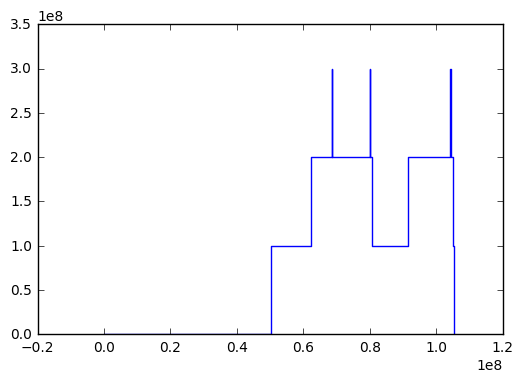

In [15]:
sess = create_session()
redirect.start();
sess.run(grads[0].op, feed_dict={a1:np.zeros((n,))})
stderr = redirect.stop()
plot_memory_timeline(stderr)

In [16]:
print_memory_timeline(stderr)

 50385696                                       a2   100000000   100000000
 62436162                 gradients/cost_grad/Tile   100000000   200000000
 68648386                                       a3   100000000   300000000
 68695205                                       a2  -100000000   200000000
 80062870               gradients/a3_grad/TanhGrad   100000000   300000000
 80151949                                       a3  -100000000   200000000
 80628014                 gradients/cost_grad/Tile  -100000000   100000000
 91433279                                     a2_1   100000000   200000000
104269881               gradients/a2_grad/TanhGrad   100000000   300000000
104355949                                     a2_1  -100000000   200000000
104935598               gradients/a3_grad/TanhGrad  -100000000   100000000
105331258               gradients/a2_grad/TanhGrad  -100000000           0
